In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import colors
from fidap import fidap_client
from config import api_key
import geopandas as gpd
from shapely import wkt

# instantiate api connection
fidap = fidap_client(api_key=api_key)

### Exploratory Data Analysis

#### Population Changes in Manhattan

For the sake of this notebook, let us just say that I do not really know much about the `Census US` dataset available on Fidap except for the fact that I can query for demographic data by states. Of course, I know that I can narrow it down from there but I am not quite sure how yet. So this will be an exploratory data processing journey, if you will. 

In [2]:
### SQL query to get population numbers for manhattan
### use a limit to reduce file size since we are just sizing it up
ny_trial_sql = fidap.sql("""
SELECT *
FROM fidap-301014.census.census
WHERE state = '36'
LIMIT 30;
""")

Now that we have successfully obtained the data, we should take a look at its structure. 

In [5]:
ny_trial_sql.head(n=10)

,name,total_population,median_income,median_household_income,male_pop,female_pop,median_age,white_population,black_population,american_indian_population,asian_population,housing_units,vacant_housing_units,vacant_housing_units_for_sale,state,zip_code,year
0,ZCTA5 06390,303,51970,152652,171,132,51.0,297,0,0,0,819,701,0,36,6390,2016
1,ZCTA5 06390,230,50703,150703,134,96,52.5,223,0,0,0,820,743,0,36,6390,2017
2,ZCTA5 06390,296,78000,151333,152,144,52.6,296,0,0,0,755,623,0,36,6390,2014
3,ZCTA5 06390,339,54519,151083,187,152,52.5,331,0,0,0,789,655,0,36,6390,2015
4,ZCTA5 06390,183,52692,-666666666,110,73,58.9,175,0,0,0,758,685,0,36,6390,2018
5,ZCTA5 06390,125,30469,61125,75,50,44.6,117,0,0,0,669,629,0,36,6390,2019
6,ZCTA5 06390,280,66250,151250,127,153,48.2,280,0,0,0,639,508,0,36,6390,2011
7,ZCTA5 06390,307,67778,146917,137,170,48.3,307,0,0,0,628,483,0,36,6390,2012
8,ZCTA5 06390,291,68438,149554,144,147,47.6,291,0,0,0,682,561,0,36,6390,2013
9,ZCTA5 10001,23332,56198,85168,12116,11216,35.8,14814,2235,32,5000,13520,1553,8,36,10001,2016


Right, so we know that we can actually query by zip code. But the annoying thing is that the zip code column is a string and not an integer. This means that we cannot simply use an equality operator to filter for zip code. Instead we have to list them out manually. But we do not want to do so.  
I know that Manhattan's zip codes run from 10001 through 10282 inclusive. Although not every number between 10001 and 10282 is a zip code in use. But regardless, I can still first limit the query by searching for zip codes that start with 10.  
US Census data tends to include fields with values like -66666 if they are derived from some other columns where division by zero occurs, such as median age. Filtering for median age more than or equals to zero reduces the odds of such problematic rows to begin with. 

In [6]:
nyc_dem_sql = fidap.sql("""
SELECT *
FROM fidap-301014.census.census
WHERE state = '36'
AND zip_code LIKE '10%'
AND median_age >= 0
AND median_income >= 0
AND median_household_income >= 0
""")

In [7]:
# creating a copy
nyc_dem = nyc_dem_sql.copy()

# coerce to type int
nyc_dem.zip_code = nyc_dem.zip_code.astype(int)

# manhattan zips
mn_zips = np.arange(10001, 10283).tolist()

# manhattan records
mn_dem = nyc_dem[nyc_dem.zip_code.isin(mn_zips)]

#### Broad Demographics  

Okay. Let us look at broad demographic trends such as median age, total population, housing units available, and household income in Manhattan over the past few years for which data is available. 

In [8]:
agg_dems = mn_dem.groupby('year').agg({
    'total_population': 'sum',
    'median_income': 'mean',
    'median_household_income': 'mean',
    'housing_units': 'sum'})

In [9]:
agg_dems

,total_population,median_income,median_household_income,housing_units
year,,,,
2011,1579594,53581.155556,85966.244444,839443
2012,1587045,55292.066667,87300.533333,843368
2013,1596007,56598.377778,88988.933333,845824
2014,1608966,58247.088889,93221.933333,854560
2015,1428352,56130.500000,89282.861111,748356
2016,1625513,61004.288889,95989.666667,863014
2017,1643736,61913.911111,101477.511111,868772
2018,1621623,64497.511111,105486.777778,870148
2019,1621356,67303.866667,110433.866667,875923


What we can see is that the total population of Manhattan has increased by about 2.5% between 2011 and 2019. More interestingly, the growth in individual median income, median household income, and housing units have outpaced population growth at 25%, 28%, and 4.3% respectively.  
  
What is rather peculiar is the anomalous dip across the board in 2015. There could either be a genuine dip due to economic conditions or a problem with the data stemming from its querying or raw data collection. We can try to find out what is going on and troubleshoot from there.  

#### Missing Data?

To figure out what is going on, we can try to query and compare the two datasets side by side. 

In [10]:
## sql querying
nyc_2015_dem_sql = fidap.sql("""
SELECT *
FROM fidap-301014.census.census
WHERE state = '36'
AND zip_code LIKE '10%'
AND year = 2015
AND median_age >= 0
AND median_income >= 0
AND median_household_income >= 0;
""")

# creating a copy
nyc_2015_dem = nyc_2015_dem_sql.copy()
# coerce to type int
nyc_2015_dem.zip_code = nyc_2015_dem.zip_code.astype(int)
# manhattan records
mn_2015_dem = nyc_2015_dem[nyc_2015_dem.zip_code.isin(mn_zips)]
# check mn_2015_dem dimensions
print(mn_2015_dem.shape)

(36, 17)


In [11]:
mn_2016_dem = mn_dem[mn_dem.year == 2016]
print(mn_2016_dem.shape)

(45, 17)


Okay. There is a discrepancy in the number of rows, and this could mean that data was missing. We can further confirm this by identifying the rows that were missing in 2015, and seeing what their values were in 2016. 

In [12]:
missing_2015 = mn_2016_dem[~mn_2016_dem.zip_code.isin(mn_2015_dem.zip_code.tolist())]
missing_2015

,name,total_population,median_income,median_household_income,male_pop,female_pop,median_age,white_population,black_population,american_indian_population,asian_population,housing_units,vacant_housing_units,vacant_housing_units_for_sale,state,zip_code,year
36,ZCTA5 10005,8710,79388,130116,4201,4509,29.5,6425,245,0,1625,5187,892,0,36,10005,2016
71,ZCTA5 10010,32854,71787,110142,16606,16248,35.0,24356,1867,214,4963,17923,1853,9,36,10010,2016
97,ZCTA5 10013,28211,51811,104167,13988,14223,36.9,15813,1371,36,9039,13913,1979,98,36,10013,2016
132,ZCTA5 10018,9684,70650,105479,4818,4866,31.2,5724,532,0,2842,5910,954,14,36,10018,2016
167,ZCTA5 10023,60307,81953,115080,27235,33072,42.5,49506,2060,111,6270,41114,7970,61,36,10023,2016
229,ZCTA5 10030,30358,20628,33720,14530,15828,34.1,4829,19828,133,704,13196,1318,38,36,10030,2016
291,ZCTA5 10037,20112,25718,39463,8762,11350,34.9,2161,14880,6,503,10086,769,81,36,10037,2016
371,ZCTA5 10162,1253,130898,178822,575,678,41.3,1069,0,0,94,783,158,0,36,10162,2016
388,ZCTA5 10282,5635,130313,250001,2908,2727,34.5,3986,78,0,1243,2904,470,0,36,10282,2016


In [13]:
missing_nyc_2015_dem_sql = fidap.sql("""
SELECT *
FROM fidap-301014.census.census
WHERE zip_code IN ('10005', '10010', '10013', '10018', '10023', '10030', '10037', '10162', '10282')
AND year = 2015;
""")

missing_nyc_2015_dem_sql

,name,total_population,median_income,median_household_income,male_pop,female_pop,median_age,white_population,black_population,american_indian_population,asian_population,housing_units,vacant_housing_units,vacant_housing_units_for_sale,state,zip_code,year
0,ZCTA5 10005,8131,NaN,124194,3904,4227,29.4,6126,240,0,1431,5254,1002,96,36,10005,2015
1,ZCTA5 10010,31447,NaN,101718,15649,15798,34.6,22901,1938,202,5087,18044,1994,0,36,10010,2015
2,ZCTA5 10013,27415,NaN,96667,13625,13790,36.9,15066,1287,32,9281,13750,2192,109,36,10013,2015
3,ZCTA5 10018,9168,NaN,105500,4821,4347,30.7,5387,579,42,2521,5546,834,17,36,10018,2015
4,ZCTA5 10023,60586,NaN,111478,28188,32398,42.1,49823,1883,93,5836,40991,8236,123,36,10023,2015
5,ZCTA5 10030,29209,NaN,33196,13733,15476,34.1,4291,19428,121,778,13217,1326,34,36,10030,2015
6,ZCTA5 10037,18777,NaN,35491,8360,10417,36.1,2020,13752,39,451,9856,747,58,36,10037,2015
7,ZCTA5 10162,1289,NaN,193510,697,592,44.4,1243,0,0,46,808,137,0,36,10162,2015
8,ZCTA5 10282,5730,NaN,250001,3014,2716,33.0,4042,77,0,902,2885,446,0,36,10282,2015


Quite interestingly, and unfortunately, the issue was that the `median_income` column was `NaN` for some reason. That led to those 9 significant rows being left out in the query. We could requery and leave out the median income filter if we do not mind ignoring that field. 

#### Income Trends

Income inequality is a big issue. We know that over the past few years, tech hubs such as San Francisco saw increases in median incomes but also rising income inequality. Do we see the same trends among New Yorkers who live in Manhattan?  
  
We can assume that there is some sort of residential segregation along income lines. That is, the low-income most probably do not live in the same zip codes as the high-income. This might not be universally true but in New York it probably is, most of the time. What we can do is to obtain every other decile of median household incomes grouped by zip code for each year. 

In [14]:
### re-query based on what we saw above
nyc_dem_sql_2 = fidap.sql("""
SELECT *
FROM fidap-301014.census.census
WHERE state = '36'
AND zip_code LIKE '10%'
AND median_age >= 0
AND median_household_income >= 0
""")

# creating a copy
nyc_dem = nyc_dem_sql_2.copy()

# coerce to type int
nyc_dem.zip_code = nyc_dem.zip_code.astype(int)

# manhattan zips
mn_zips = np.arange(10001, 10283).tolist()

# manhattan records
mn_dem = nyc_dem[nyc_dem.zip_code.isin(mn_zips)]

In [15]:
mn_dem_decile = mn_dem.copy()
mn_dem_decile.year = mn_dem_decile.year.astype(str)

mn_MHI_decile = mn_dem_decile.groupby('year').agg(
    First = ('median_household_income', lambda x: x.quantile(0.1)),
    Third = ('median_household_income', lambda x: x.quantile(0.3)),
    Fifth = ('median_household_income', 'median'),
    Seventh = ('median_household_income', lambda x: x.quantile(0.7)),
    Ninth = ('median_household_income', lambda x: x.quantile(0.9))
)
mn_MHI_decile
mn_MHI_decile = mn_MHI_decile.reset_index()

Text(0.5, 0.98, 'Household Income Divergence')

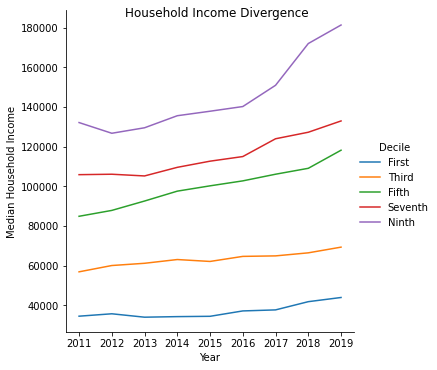

In [16]:
# pivot table to long for effective plotting
mn_MHI_long = pd.melt(mn_MHI_decile, id_vars = 'year', value_vars = ['First', 'Third', 'Fifth', 'Seventh', 'Ninth' ])

# renaming cols
mn_MHI_long.columns = ['Year', 'Decile', 'Median Household Income']

# plotting
ax = sns.relplot(
    data = mn_MHI_long,
    x = 'Year',
    y = 'Median Household Income',
    hue = 'Decile',
    kind = 'line')
ax.fig.suptitle('Household Income Divergence')

Between 2011 and 2019 inclusive, there is no evidence of convergence in terms of household income. Yes, household incomes may have risen across the board but they have done so at different rates.  
  
Households at the top two deciles saw their incomes rise faster than everyone else, especially after 2016. More worryingly, income growth for households at the bottom three deciles appear to be slowing down, contributing to larger divergence despite continued economic growth.  
  
Can we see this how has played out over the years in the form of a map? Yes! With `geopandas`, spatial files can be read like a regular data frame and then plotted.   

In [3]:
### SQL query to obtain spatial boundaries for manhattan
mn_boundaries = fidap.sql("""
SELECT * 
FROM bigquery-public-data.geo_us_boundaries.zip_codes
WHERE state_fips_code = '36'
AND city LIKE 'New York%'
AND(
zip_code LIKE '100%'
OR zip_code LIKE '101%'
OR zip_code LIKE '102%');
""")

## cleaning geometry column
mn_gdf = mn_boundaries.copy()
mn_gdf['zip_code_geom'] = mn_gdf['zip_code_geom'].apply(wkt.loads)

In [18]:
## joining the two like you would a dataframe
mn_income = mn_dem.loc[:,["median_household_income", "zip_code", "year"]]
mn_income_gdf = mn_income.merge(mn_gdf.loc[:,['zip_code', 'zip_code_geom']], left_on = 'zip_code', right_on = 'zip_code')

## coercing to type gdf
mn_income_gdf = gpd.GeoDataFrame(mn_income_gdf, geometry = 'zip_code_geom', crs = 'epsg:4326')

## filtering for 2019
mn_income_2019_gdf = mn_income_gdf.loc[mn_income_gdf.year==2019,]

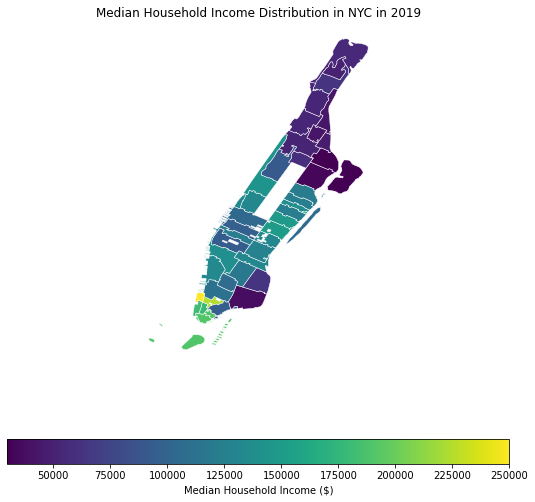

In [25]:
## plotting
f, ax = plt.subplots(figsize = (9,9))
mn_income_2019_gdf.plot(ax = ax, linewidth = 0.5, edgecolor = 'white', 
                        column = 'median_household_income', legend = True, 
                        legend_kwds = {
                            'label': 'Median Household Income ($)',
                            'orientation': 'horizontal'
                        })
ax.set_axis_off()
ax.set_title("Median Household Income Distribution in Manhattan in 2019")
plt.show()

#### Housing Units  

Okay, what about housing units? Was the growth in housing supply uniform? Were there some zip codes that saw huge increases? Let us just start with the difference between 2011 and 2019.

In [30]:
## getting df of just housing units for 2011 and 2019

mn_housing = mn_dem.loc[:,['housing_units', 'year', 'zip_code']]

mn_housing_wide_years = mn_housing.pivot(index = 'zip_code', columns = 'year', values = 'housing_units')

mn_housing_2011_2019 = mn_housing_wide_years.iloc[:,[0, 8]]
mn_housing_2011_2019.columns = ['2011', '2019']

mn_housing_2011_2019 = mn_housing_2011_2019.assign(
    difference = lambda x: x['2019']-x['2011'],
    pct_difference = lambda x: 100 * x['difference']/x['2011']
)

## joining with gdf
mn_housing_2011_2019 = mn_housing_2011_2019.merge(mn_gdf.loc[:,['zip_code', 'zip_code_geom']], on = 'zip_code')
mn_housing_2011_2019 = gpd.GeoDataFrame(mn_housing_2011_2019, geometry = 'zip_code_geom', crs = 'epsg:4326')


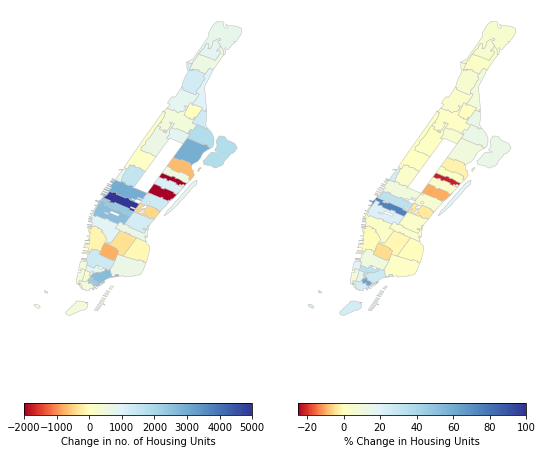

In [63]:
## plotting absolute difference
## manually telling mpl where the breakpoints should be
### otherwise, it will be normally distributed and will not correspond to the ones you want
divnorm1 = colors.TwoSlopeNorm(vmin = -2000, vcenter = 0, vmax = 5000)
divnorm2 = colors.TwoSlopeNorm(vmin = -25, vcenter = 0, vmax = 100)

f, (ax1, ax2) = plt.subplots(1,2,figsize = (9,9), sharey = True)
mn_housing_2011_2019.plot(ax = ax1, linewidth = 0.5, edgecolor = '#bdbdbd', 
                        column = 'difference', legend = True, norm = divnorm1, cmap = 'RdYlBu',
                        legend_kwds = {
                            'label': 'Change in no. of Housing Units',
                            'orientation': 'horizontal'
                        })
mn_housing_2011_2019.plot(ax = ax2, linewidth = 0.5, edgecolor = '#bdbdbd', 
                        column = 'pct_difference', legend = True, norm = divnorm2, cmap = 'RdYlBu',
                        legend_kwds = {
                            'label': '% Change in Housing Units',
                            'orientation': 'horizontal'
                        })
ax1.set_axis_off()
ax2.set_axis_off()
plt.show()

Well, we see in most places, there was an increase in the availability of housing stock. The next question we need to ask ourselves is, to what extent is that housing distributed by income? 

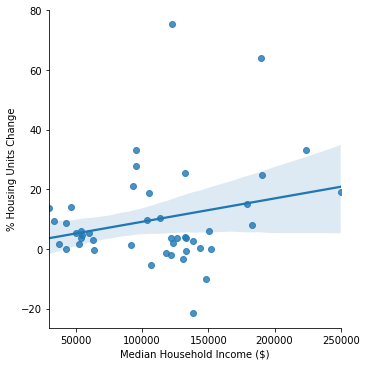

In [67]:
mn_housing_income = mn_housing_2011_2019.merge(mn_income_2019_gdf, on = 'zip_code')
m = sns.lmplot(x = 'median_household_income', y = 'pct_difference', data = mn_housing_income)
m = (m.set_axis_labels('Median Household Income ($)', '% Housing Units Change')).set(xticks = [50000, 100000, 150000, 200000, 250000])

What we see here is a weak positive correlation between median household income and changes in the number of housing units avaiilable between 2011 and 2019.